# Structured data classification from scratch

**Author:** [fchollet](https://twitter.com/fchollet)<br>
**Date created:** 2020/06/09<br>
**Last modified:** 2020/06/09<br>
**Description:** Binary classification of structured data including numerical and categorical features.

## Introduction

This example demonstrates how to do structured data classification, starting from a raw
CSV file. Our data includes both numerical and categorical features. We will use Keras
preprocessing layers to normalize the numerical features and vectorize the categorical
ones.

Note that this example should be run with TensorFlow 2.5 or higher.

### The dataset

[Our dataset](https://archive.ics.uci.edu/ml/datasets/heart+Disease) is provided by the
Cleveland Clinic Foundation for Heart Disease.
It's a CSV file with 303 rows. Each row contains information about a patient (a
**sample**), and each column describes an attribute of the patient (a **feature**). We
use the features to predict whether a patient has a heart disease (**binary
classification**).

Here's the description of each feature:

Column| Description| Feature Type
------------|--------------------|----------------------
Age | Age in years | Numerical
Sex | (1 = male; 0 = female) | Categorical
CP | Chest pain type (0, 1, 2, 3, 4) | Categorical
Trestbpd | Resting blood pressure (in mm Hg on admission) | Numerical
Chol | Serum cholesterol in mg/dl | Numerical
FBS | fasting blood sugar in 120 mg/dl (1 = true; 0 = false) | Categorical
RestECG | Resting electrocardiogram results (0, 1, 2) | Categorical
Thalach | Maximum heart rate achieved | Numerical
Exang | Exercise induced angina (1 = yes; 0 = no) | Categorical
Oldpeak | ST depression induced by exercise relative to rest | Numerical
Slope | Slope of the peak exercise ST segment | Numerical
CA | Number of major vessels (0-3) colored by fluoroscopy | Both numerical & categorical
Thal | 3 = normal; 6 = fixed defect; 7 = reversible defect | Categorical
Target | Diagnosis of heart disease (1 = true; 0 = false) | Target

## Setup

In [1]:
import os

os.environ["KERAS_BACKEND"] = "torch"  # or torch, or tensorflow

import pandas as pd
import keras
from keras import layers

## Preparing the data

Let's download the data and load it into a Pandas dataframe:

In [2]:
file_url = "heart.csv"
dataframe = pd.read_csv(file_url)

The dataset includes 303 samples with 14 columns per sample (13 features, plus the target
label):

In [3]:
dataframe.shape

(303, 14)

Here's a preview of a few samples:

In [4]:
dataframe.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,0,145,233,1,2,150,0,2.3,2,0,2,0
1,67,1,3,160,286,0,2,108,1,1.5,1,3,1,1
2,67,1,3,120,229,0,2,129,1,2.6,1,2,3,1
3,37,1,2,130,250,0,0,187,0,3.5,2,0,1,0
4,41,0,1,130,204,0,2,172,0,1.4,0,0,1,0


The last column, "target", indicates whether the patient has a heart disease (1) or not
(0).

Let's split the data into a training and validation set:

In [5]:
val_dataframe = dataframe.sample(frac=0.2, random_state=1337)
train_dataframe = dataframe.drop(val_dataframe.index)

print(
    f"Using {len(train_dataframe)} samples for training "
    f"and {len(val_dataframe)} for validation"
)

Using 242 samples for training and 61 for validation


## Define dataset metadata

Here, we define the metadata of the dataset that will be useful for reading and
parsing the data into input features, and encoding the input features with respect
to their types.

In [6]:
COLUMN_NAMES = [
    "age",
    "sex",
    "cp",
    "trestbps",
    "chol",
    "fbs",
    "restecg",
    "thalach",
    "exang",
    "oldpeak",
    "slope",
    "ca",
    "thal",
    "target",
]
# Target feature name.
TARGET_FEATURE_NAME = "target"
# Numeric feature names.
NUMERIC_FEATURE_NAMES = ["age", "trestbps", "thalach", "oldpeak", "slope", "chol"]
# Categorical features and their vocabulary lists.
# Note that we add 'v=' as a prefix to all categorical feature values to make
# sure that they are treated as strings.

CATEGORICAL_FEATURES_WITH_VOCABULARY = {
    feature_name: sorted(
        [
            # Integer categorcal must be int and string must be str
            value if dataframe[feature_name].dtype == "int64" else str(value)
            for value in list(dataframe[feature_name].unique())
        ]
    )
    for feature_name in COLUMN_NAMES
    if feature_name not in list(NUMERIC_FEATURE_NAMES + [TARGET_FEATURE_NAME])
}
# All features names.
FEATURE_NAMES = NUMERIC_FEATURE_NAMES + list(CATEGORICAL_FEATURES_WITH_VOCABULARY.keys()
)

## Feature preprocessing with Keras layers


The following features are categorical features encoded as integers:

- `sex`
- `cp`
- `fbs`
- `restecg`
- `exang`
- `ca`

We will encode these features using **one-hot encoding**. We have two options
here:

 - Use `CategoryEncoding()`, which requires knowing the range of input values
 and will error on input outside the range.
 - Use `IntegerLookup()` which will build a lookup table for inputs and reserve
 an output index for unkown input values.

For this example, we want a simple solution that will handle out of range inputs
at inference, so we will use `IntegerLookup()`.

We also have a categorical feature encoded as a string: `thal`. We will create an
index of all possible features and encode output using the `StringLookup()` layer.

Finally, the following feature are continuous numerical features:

- `age`
- `trestbps`
- `chol`
- `thalach`
- `oldpeak`
- `slope`

For each of these features, we will use a `Normalization()` layer to make sure the mean
of each feature is 0 and its standard deviation is 1.

Below, we define 2 utility functions to do the operations:

- `encode_numerical_feature` to apply featurewise normalization to numerical features.
- `process` to one-hot encode string or integer categorical features.

In [7]:
# Tensorflow required for tf.data.Dataset
import tensorflow as tf

# We process our datasets elements here (categorical) and convert them to indices to avoid this step
# during model training since only tensorflow support strings.
def encode_categorical(features, target):
    for feature_name in features:
        if feature_name in CATEGORICAL_FEATURES_WITH_VOCABULARY:
            lookup_class = (
                layers.StringLookup
                if features[feature_name].dtype == "string"
                else layers.IntegerLookup
            )
            vocabulary = CATEGORICAL_FEATURES_WITH_VOCABULARY[feature_name]
            # Create a lookup to convert a string values to an integer indices.
            # Since we are not using a mask token nor expecting any out of vocabulary
            # (oov) token, we set mask_token to None and  num_oov_indices to 0.
            index = lookup_class(
                vocabulary=vocabulary,
                mask_token=None,
                num_oov_indices=0,
                output_mode="binary",
            )
            # Convert the string input values into integer indices.
            value_index = index(features[feature_name])
            features[feature_name] = value_index

        else:
            pass

    # Change features from OrderedDict to Dict to match Inputs as they are Dict.
    return dict(features), target

def encode_numerical_feature(feature, name, dataset):
    # Create a Normalization layer for our feature
    normalizer = layers.Normalization()
    # Prepare a Dataset that only yields our feature
    feature_ds = dataset.map(lambda x, y: x[name])
    feature_ds = feature_ds.map(lambda x: tf.expand_dims(x, -1))
    # Learn the statistics of the data
    normalizer.adapt(feature_ds)
    # Normalize the input feature
    encoded_feature = normalizer(feature)
    return encoded_feature

Let's generate `tf.data.Dataset` objects for each dataframe:

In [8]:
def dataframe_to_dataset(dataframe):
    dataframe = dataframe.copy()
    labels = dataframe.pop("target")
    ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels)).map(
        encode_categorical
    )
    ds = ds.shuffle(buffer_size=len(dataframe))
    return ds

train_ds = dataframe_to_dataset(train_dataframe)
val_ds = dataframe_to_dataset(val_dataframe)

Each `Dataset` yields a tuple `(input, target)` where `input` is a dictionary of features
and `target` is the value `0` or `1`:

In [9]:
for x, y in train_ds.take(1):
    print("Input:", x)
    print("Target:", y)

Input: {'age': <tf.Tensor: shape=(), dtype=int64, numpy=55>, 'sex': <tf.Tensor: shape=(2,), dtype=int64, numpy=array([1, 0])>, 'cp': <tf.Tensor: shape=(4,), dtype=int64, numpy=array([0, 1, 0, 0])>, 'trestbps': <tf.Tensor: shape=(), dtype=int64, numpy=135>, 'chol': <tf.Tensor: shape=(), dtype=int64, numpy=250>, 'fbs': <tf.Tensor: shape=(2,), dtype=int64, numpy=array([1, 0])>, 'restecg': <tf.Tensor: shape=(3,), dtype=int64, numpy=array([0, 0, 1])>, 'thalach': <tf.Tensor: shape=(), dtype=int64, numpy=161>, 'exang': <tf.Tensor: shape=(2,), dtype=int64, numpy=array([1, 0])>, 'oldpeak': <tf.Tensor: shape=(), dtype=float64, numpy=1.4>, 'slope': <tf.Tensor: shape=(), dtype=int64, numpy=1>, 'ca': <tf.Tensor: shape=(4,), dtype=int64, numpy=array([1, 0, 0, 0])>, 'thal': <tf.Tensor: shape=(3,), dtype=int64, numpy=array([1, 0, 0])>}
Target: tf.Tensor(0, shape=(), dtype=int64)


Let's batch the datasets:

In [10]:
train_ds = train_ds.batch(32)
val_ds = val_ds.batch(32)

## Build a model

With this done, we can create our end-to-end model:

In [11]:
# Categorical features have different shapes after the encoding, dependent on the
# vocabulary or unique values of each feature. We create them accordinly to match the
# input data elements generated by tf.data.Dataset after pre-processing them
def create_model_inputs():
    inputs = {}

    # This a helper function for creating categorical features
    def create_input_helper(feature_name):
        num_categories = len(CATEGORICAL_FEATURES_WITH_VOCABULARY[feature_name])
        inputs[feature_name] = layers.Input(name=feature_name, shape=(num_categories,), dtype="int64"
        )
        return inputs

    for feature_name in FEATURE_NAMES:
        if feature_name in CATEGORICAL_FEATURES_WITH_VOCABULARY:
            # Categorical features
            create_input_helper(feature_name)
        else:
            # Make them float32, they are Real numbers
            feature_input = layers.Input(name=feature_name, shape=(1,), dtype="float32")
            # Process the Inputs here
            inputs[feature_name] = encode_numerical_feature(feature_input, feature_name, train_ds
            )
    return inputs

# This Layer defines the logic of the Model to perform the classification
class Classifier(keras.layers.Layer):

    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.dense_1 = layers.Dense(32, activation="relu")
        self.dropout = layers.Dropout(0.5)
        self.dense_2 = layers.Dense(1, activation="sigmoid")

    def call(self, inputs):
        all_features = layers.concatenate(list(inputs.values()))
        x = self.dense_1(all_features)
        x = self.dropout(x)
        output = self.dense_2(x)
        return output

    # Surpress build warnings
    def build(self, input_shape):
        self.built = True

# Create the Classifier model
def create_model():
    all_inputs = create_model_inputs()
    output = Classifier()(all_inputs)
    model = keras.Model(all_inputs, output)
    return model

model = create_model()
model.compile("adam", "binary_crossentropy", metrics=["accuracy"])

/usr/local/lib/python3.12/dist-packages/keras/src/models/functional.py:107: UserWarning: When providing `inputs` as a dict, all keys in the dict must match the names of the corresponding tensors. Received key 'age' mapping to value <KerasTensor shape=(None, 1), dtype=float32, sparse=False, ragged=False, name=keras_tensor> which has name 'keras_tensor'. Change the tensor name to 'age' (via `Input(..., name='age')`)
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/keras/src/models/functional.py:107: UserWarning: When providing `inputs` as a dict, all keys in the dict must match the names of the corresponding tensors. Received key 'trestbps' mapping to value <KerasTensor shape=(None, 1), dtype=float32, sparse=False, ragged=False, name=keras_tensor_1> which has name 'keras_tensor_1'. Change the tensor name to 'trestbps' (via `Input(..., name='trestbps')`)
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/keras/src/models/functional.py:107: UserWarning: When providing `inputs

Let's visualize our connectivity graph:

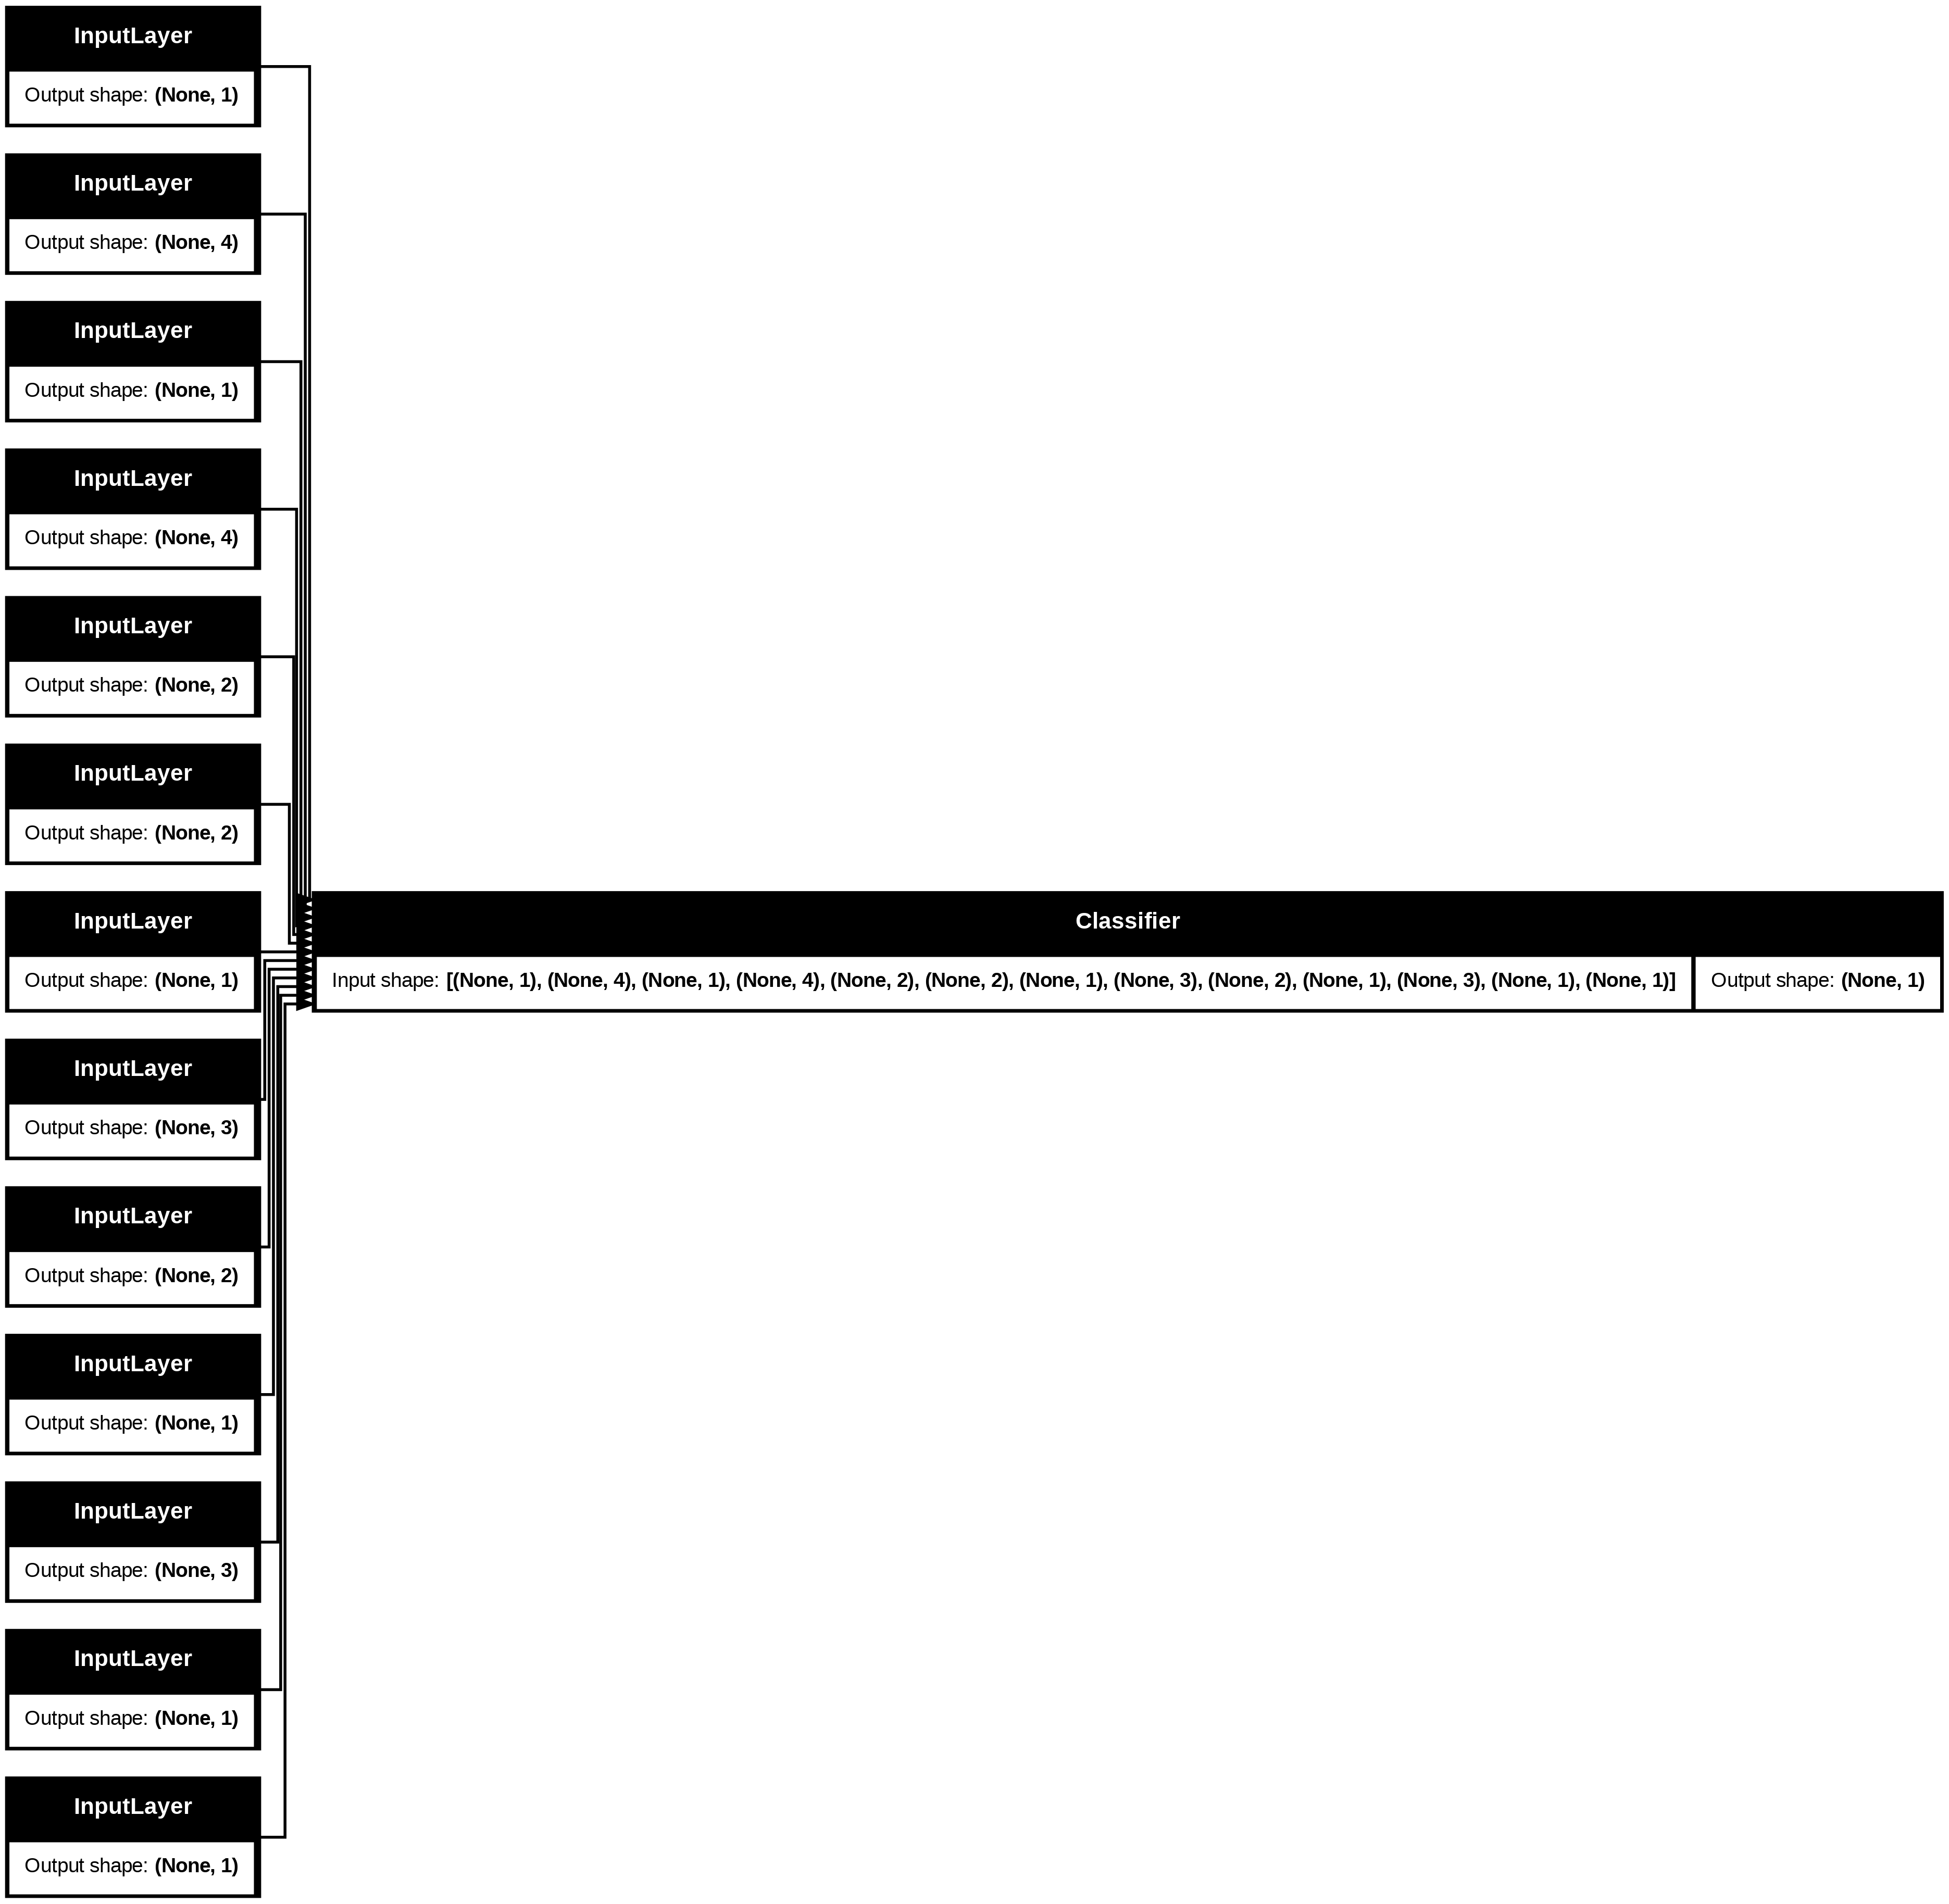

In [12]:
# `rankdir='LR'` is to make the graph horizontal.
# Genera un diagrama visual del modelo de Keras que se le pase como argumento. Este diagrama es útil para entender la arquitectura de la red neuronal,
#ya que muestra las capas y la forma en que los datos fluyen a través de ellas.
keras.utils.plot_model(model, show_shapes=True, rankdir="LR")

## Train the model

In [13]:
model.fit(train_ds, epochs=50, validation_data=val_ds)

Epoch 1/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.4766 - loss: 7.7238 - val_accuracy: 0.5738 - val_loss: 6.8201
Epoch 2/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.5303 - loss: 6.4121 - val_accuracy: 0.5738 - val_loss: 6.8212
Epoch 3/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.5786 - loss: 5.8094 - val_accuracy: 0.5738 - val_loss: 6.5432
Epoch 4/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.5717 - loss: 6.3235 - val_accuracy: 0.5738 - val_loss: 6.0162
Epoch 5/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.5604 - loss: 6.2441 - val_accuracy: 0.5738 - val_loss: 6.2495
Epoch 6/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.5639 - loss: 6.3174 - val_accuracy: 0.5738 - val_loss: 6.2592
Epoch 7/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.4978 - loss: 7.2639 - val_accuracy: 0.5738 - val_loss: 6.0856
Epoch 8/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.5112 - loss: 7.1358 - val_accuracy: 0.5738 - val_loss: 6.3609


We quickly get to 80% validation accuracy.

## Inference on new data

To get a prediction for a new sample, you can simply call `model.predict()`. There are
just two things you need to do:

1. wrap scalars into a list so as to have a batch dimension (models only process batches
of data, not single samples)
2. Call `convert_to_tensor` on each feature

In [14]:
sample = {
    "age": 60,
    "sex": 1,
    "cp": 1,
    "trestbps": 145,
    "chol": 233,
    "fbs": 1,
    "restecg": 2,
    "thalach": 150,
    "exang": 0,
    "oldpeak": 2.3,
    "slope": 3,
    "ca": 0,
    "thal": "fixed",
}

# Given the category (in the sample above - key) and the category value (in the sample above - value),
# we return its one-hot encoding
def get_cat_encoding(cat, cat_value):
    # Create a list of zeros with the same length as categories
    encoding = [0] * len(cat)
    # Find the index of category_value in categories and set the corresponding position to 1
    if cat_value in cat:
        encoding[cat.index(cat_value)] = 1
    return encoding

for name, value in sample.items():
    if name in CATEGORICAL_FEATURES_WITH_VOCABULARY:
        sample.update(
            {
                name: get_cat_encoding(
                    CATEGORICAL_FEATURES_WITH_VOCABULARY[name], sample[name]
                )
            }
        )
# Convert inputs to tensors
input_dict = {name: tf.convert_to_tensor([value]) for name, value in sample.items()}
predictions = model.predict(input_dict)

print(
    f"This particular patient had a {100 * predictions[0][0]:.1f} "
    "percent probability of having a heart disease, "
    "as evaluated by our model."
)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step
This particular patient had a 0.0 percent probability of having a heart disease, as evaluated by our model.


## Conclusions

- The orignal model (the one that runs only on tensorflow) converges quickly to around 80% and remains
there for extended periods and at times hits 85%
- The updated model (the backed-agnostic) model may fluctuate between 78% and 83% and at times hitting 86%
validation accuracy and converges around 80% also.